In [1]:
# Generate simulation data

In [5]:
import sys
sys.path.append("./mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [6]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import numpy as np
import numpy.random as npr
from data_gen import MyDataGen
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm


from cp_predict import CPNaive, CPSimple, CPSimple1

In [12]:
xysize = (10, 1)
A = npr.randn(*xysize).T;
ntrain = 1000;
ntest = 10000;
noise_std = 1
model_type = "SVR"
verbose = 2
alpha = 0.2

0.2

In [13]:
def _get_model(typ="SVR"):
    if typ == "SVR":
        return SVR(kernel="rbf")
    elif typ == "MLP":
        return MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)


def _gen_data(ntrain, seed):
    A = npr.randn(*xysize).T;
    datagen = MyDataGen(xysize=xysize, A=A);
    np.random.seed(seed)
    seeds = npr.randint(0, 1000000, 2)    
    Xtrain, Ytrain = datagen(n=ntrain, noise_std=noise_std, seed=seeds[0]);
    Xtest, Ytest = datagen(n=10000, noise_std=noise_std, seed=seeds[1]);
    return Xtrain, Ytrain, Xtest, Ytest

In [14]:
seed = 0
Xtrain, Ytrain, Xtest, Ytest = _gen_data(ntrain, seed)
fmodel = _get_model(typ="MLP")
fmodel.fit(Xtrain, Ytrain); 
gmodel = _get_model(typ=model_type)
gmodel.fit(Xtrain, Ytrain**2);

cur_ys_train, cur_fs_train, cur_gs_train = Ytrain, fmodel.predict(Xtrain), gmodel.predict(Xtrain)
cur_ys_test, cur_fs_test, cur_gs_test = Ytest, fmodel.predict(Xtest), gmodel.predict(Xtest)

/home/hujin/jin/conda/envs/imageCP/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
x = np.random.randn(10, 1, 2, 1)
x.squeeze(1).shape

(10, 2, 1)

In [4]:
cpfit = CPSimple(cur_ys_train, cur_fs_train, cur_gs_train, 
                 kernel_fn=None, 
                 M=None,
                 verbose=verbose)

NameError: name 'CPSimple' is not defined

In [21]:
cpfit.gs - cpfit.fs**2

array([[ 1.39906403,  3.29640972],
       [ 0.1601075 , -3.45442751],
       [ 1.24167078, -1.5702444 ],
       ...,
       [ 1.22209564,  2.83464971],
       [-0.50548442, -0.56013241],
       [ 1.69865581, -1.03053814]])

In [20]:
cpfit.M

array([0.51176638, 0.54450189])

In [19]:
hfct = 2e-3
cpfit = CPSimple(cur_ys_train, cur_fs_train, cur_gs_train, 
                 kernel_fn=None, 
                 M=None,
                 verbose=verbose)
cpfit_naive = CPNaive(cur_ys_train, cur_fs_train, cur_gs_train, 
                      kernel_fn=None, 
                      M = None,
                      verbose=verbose)
cpfit_naive.fit(alpha=alpha)
h = CPSimple1.get_base_h(hfct, cpfit, eps_naive=cpfit_naive.eps, alpha=alpha)
cpfit.fit(alpha=alpha, h=h, opt_params={"bds": (0.01, 1000)})
_, in_sets = cpfit.predict(cur_fs_test, cur_ys_test);

In [10]:
split_ratio = 0.5
tr_idxs = np.sort(npr.choice(ntrain, int(ntrain*split_ratio), replace=False))
Xtrain1, Ytrain1 = Xtrain[tr_idxs], Ytrain[tr_idxs]
Xtrain2, Ytrain2 = np.delete(Xtrain, tr_idxs, axis=0), np.delete(Ytrain, tr_idxs, axis=0)
fmodel1 = _get_model(typ="SVR")
fmodel1.fit(Xtrain1, Ytrain1); 
gmodel1 = _get_model(typ=model_type)
gmodel1.fit(Xtrain1, Ytrain1**2);
cur_ys_train2, cur_fs_train2, cur_gs_train2 = Ytrain2, fmodel1.predict(Xtrain2), gmodel1.predict(Xtrain2)
cur_ys_test_naive, cur_fs_test_naive, _ = Ytest, fmodel1.predict(Xtest), gmodel1.predict(Xtest)

cpfit_naive = CPNaive(cur_ys_train2, cur_fs_train2, cur_gs_train2, 
                      kernel_fn=None, 
                      M=None,
                      verbose=verbose)
cpfit_naive.fit(alpha=alpha)
_, in_sets_naive = cpfit_naive.predict(cur_fs_test_naive, cur_ys_test_naive)

/home/hujin/jin/conda/envs/imageCP/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/hujin/jin/conda/envs/imageCP/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
print(cpfit.eps, cpfit_naive.eps)
print(in_sets.mean(), in_sets_naive.mean())

1.6878179434818745 1.6930073503734653
0.6691 0.7801


In [12]:
epss = np.logspace(-4, 3, 50)
vs = []
for eps in epss: 
    v = cpfit._phi_fn(eps, alpha=alpha, h=1).mean()
    vs.append(v)


In [13]:
hs = np.logspace(-5, 3, 500)
epss = []
covprobs = []
for h in tqdm(hs):
    cpfit.fit(alpha=alpha, h=h, opt_params={"bds": (0.01, 1000)})
    Rs_test, in_sets = cpfit.predict(cur_fs_test, cur_ys_test);
    epss.append(cpfit.eps)
    covprobs.append(in_sets.mean())

100%|█████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 151.83it/s]


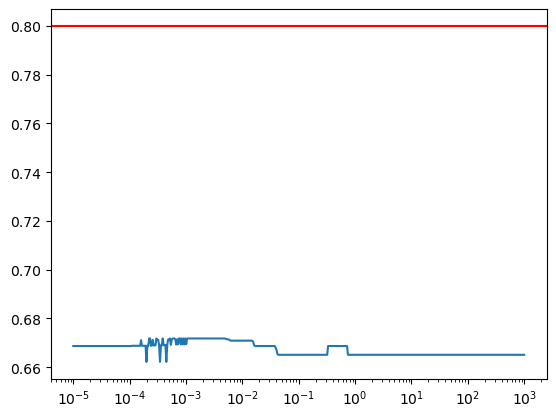

In [14]:
plt.plot(hs, covprobs)
plt.axhline(y=1-alpha, color="red")
plt.xscale("log")

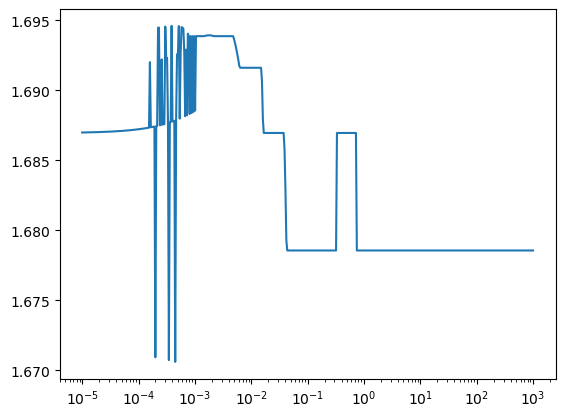

In [15]:
plt.plot(hs, epss)
plt.xscale("log")